# Import Libraries

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

# Read Dataset

In [34]:
test_df = pd.read_csv('./data/test_lAUu6dG.csv')

In [35]:
train_df = pd.read_csv('./data/train_ctrUa4K.csv')

# Dataset Overview

In [36]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [37]:
train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

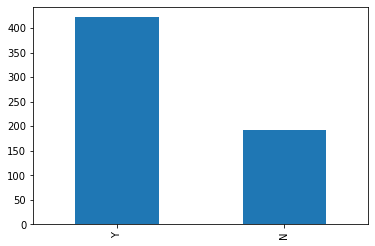

In [38]:
target = train_df['Loan_Status']
target.value_counts().plot(kind='bar')

I'm choosing to drop 'Gender', 'Married' and 'Property_Area' columns, because I don't want to use them as a parameter to approve or disaproove a loan

In [39]:
train_df = train_df.drop(columns=['Gender', 'Married', 'Property_Area', 'Loan_ID', 'CoapplicantIncome'])

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        599 non-null    object 
 1   Education         614 non-null    object 
 2   Self_Employed     582 non-null    object 
 3   ApplicantIncome   614 non-null    int64  
 4   LoanAmount        592 non-null    float64
 5   Loan_Amount_Term  600 non-null    float64
 6   Credit_History    564 non-null    float64
 7   Loan_Status       614 non-null    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 38.5+ KB


Categorical data

In [41]:
train_df.select_dtypes('object')

,Dependents,Education,Self_Employed,Loan_Status
0,0,Graduate,No,Y
1,1,Graduate,No,N
2,0,Graduate,Yes,Y
3,0,Not Graduate,No,Y
4,0,Graduate,No,Y
...,...,...,...,...
609,0,Graduate,No,Y
610,3+,Graduate,No,Y
611,1,Graduate,No,Y
612,2,Graduate,No,Y


Numerical data

In [42]:
train_df.select_dtypes(exclude='object')

,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,NaN,360.0,1.0
1,4583,128.0,360.0,1.0
2,3000,66.0,360.0,1.0
3,2583,120.0,360.0,1.0
4,6000,141.0,360.0,1.0
...,...,...,...,...
609,2900,71.0,360.0,1.0
610,4106,40.0,180.0,1.0
611,8072,253.0,360.0,1.0
612,7583,187.0,360.0,1.0


Missing values

In [43]:
train_df.isna().sum()

Dependents          15
Education            0
Self_Employed       32
ApplicantIncome      0
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
Loan_Status          0
dtype: int64

# Split train X test

In [44]:
X = train_df.drop(columns=['Loan_Status'])
y = train_df['Loan_Status'].apply(lambda x: 0 if x == 'N' else 1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Pipeline

## Preprocessing

### Categorical columns

In [46]:
cat_columns = list(X_train.select_dtypes('object').columns)
cat_columns

['Dependents', 'Education', 'Self_Employed']

Use OneHotEncoder to transform categorical data into binary numerical data  
Input missing values using KNNImputer

In [47]:
onehot_encoder = OneHotEncoder(drop='first', handle_unknown='error')

In [48]:
cat_imputer = SimpleImputer(strategy='most_frequent')

### Numerical columns

In [49]:
num_columns = list(X_train.select_dtypes(exclude='object').columns)
num_columns

['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

Imput missing values using SimpleImputer  
Standardize values

In [50]:
num_imputer = SimpleImputer(strategy='median')

In [51]:
scaler = StandardScaler()

## Pipeline for numerical and categorical data

For categorical:

In [52]:
cat_pipeline = Pipeline(steps=[('missing', cat_imputer),
                       ('encode', onehot_encoder)])

For numerical:

In [53]:
num_pipeline = Pipeline(steps=[('missing', num_imputer),
                       ('scaler', scaler)])

### Transform columns

In [54]:
dataprep = ColumnTransformer(transformers=[('num_transform', num_pipeline, num_columns),
                                           ('cat_transform', cat_pipeline, cat_columns)])

## Pipeline for model (logistic regression)

In [55]:
model = LogisticRegression(n_jobs=-1)

In [56]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modeling', model)])

In [57]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('missing',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

Cross Validation

In [58]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=KFold(10, shuffle=True))
(np.mean(scores), np.std(scores))

(0.730421792722394, 0.0623215848545734)

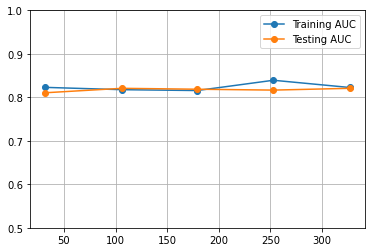

In [59]:
curves = learning_curve(pipeline, X_train, y_train, cv=KFold(n_splits=3, shuffle=True))

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Testing AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

## Pipeline for model (Decision Tree)

In [60]:
model = DecisionTreeClassifier(max_depth=3)

In [61]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modeling', model)])

In [62]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('missing',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

Cross Validation

In [63]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=KFold(10, shuffle=True))
(np.mean(scores), np.std(scores))

(0.7085845864692338, 0.05313159566960189)

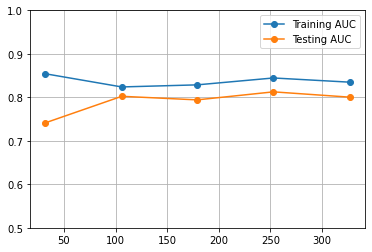

In [66]:
curves = learning_curve(pipeline, X_train, y_train, cv=KFold(n_splits=3, shuffle=True))

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Testing AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

## Pipeline for model (LGBM)

In [67]:
model = LGBMClassifier(max_depth=2, n_estimators=50)

In [68]:
pipeline = Pipeline(steps=[('preprocessing', dataprep),
                           ('modeling', model)])

In [69]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transform',
                                                  Pipeline(memory=None,
                                                           steps=[('missing',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

Cross Validation

In [70]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=KFold(10, shuffle=True))
(np.mean(scores), np.std(scores))

(0.7535988338845747, 0.10474445378077046)

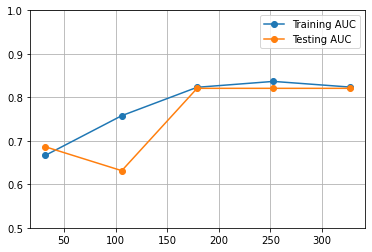

In [71]:
curves = learning_curve(pipeline, X_train, y_train, cv=KFold(n_splits=3, shuffle=True))

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]
plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Testing AUC')
plt.grid()
plt.ylim([0.5, 1])
plt.legend()

I decided to use LGBM for final model

# Saving models with PICKLE

In [72]:
joblib.dump(pipeline, 'model-lgbm.pkl')

['model-lgbm.pkl']

In [73]:
X

,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0,Graduate,No,5849,NaN,360.0,1.0
1,1,Graduate,No,4583,128.0,360.0,1.0
2,0,Graduate,Yes,3000,66.0,360.0,1.0
3,0,Not Graduate,No,2583,120.0,360.0,1.0
4,0,Graduate,No,6000,141.0,360.0,1.0
...,...,...,...,...,...,...,...
609,0,Graduate,No,2900,71.0,360.0,1.0
610,3+,Graduate,No,4106,40.0,180.0,1.0
611,1,Graduate,No,8072,253.0,360.0,1.0
612,2,Graduate,No,7583,187.0,360.0,1.0


In [ ]:
X_test

In [ ]:
X_test

In [ ]:
pipeline.predict_proba(X_test)

In [ ]:
pd.DataFrame({'Dependents': 'dependents',
                                    'Education': 'education',
                                    'Self-Employed': 'self_employed',
                                    'ApplicantIncome': 'income',
                                    'LoanAmount': 'amount',
                                    'Loan_Amount_Term': 'loan_term',
                                    'Credit_History': 'credit_history'},
            index=['julia'])